# EDA

In [3]:
import os
os.chdir('../src')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.wfdb_ext import Record
import wfdb, glob
from PIL import Image, ImageDraw, ImageFont
import src.eda as eda
from IPython.display import Image as ipy_Image
from scipy import fft
import pywt
from functools import partial
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

## Overview

The data I am using come from the [MIT-BIH Atrial Fibrillation Database](https://physionet.org/content/afdb/1.0.0/). It contains annotated ECG data from 23 unique patients each with two simultaneous 10 hour ECG signals. The annotations detailing the rythym at a given time are given in a record's `.atr` files. There are 4 different types of annotations for hearth rythyms: Atrial Fibrilation (AFIB), Atrial Flutter (AFL), AV Junction (J), and "all other rythyms" (N). The dataset mostly captures AFIB and N rythyms while AFL and J only make up around 1% of the data.

In [3]:
eda.generate_grouped_label_table()

,Total Duration (Minutes),Total Duration (%),Unique Occasions,Min Duration,Avg Duration,Long Samples (>5s)
annot,,,,,,
AFIB,5603.848067,0.40,291,420,288858.147766,275
AFL,97.951133,0.01,14,882,104947.642857,12
J,5.515533,0.00,12,380,6894.416667,8
N,8349.296133,0.59,288,1062,434859.173611,287


I am going into this project with little to no background knowledge on how ECGs work and what characteristics each rythym tends to display. So, using the data, I'm going to hypothesize the characteristics of each rythym then compare my hypotheses with existing literature.

## Time Domain Analysis

First, I've curated a small random sample that has decent variation (My sampling method struggles with AFL and J due to the low number of records that contain these rythyms) which I have plotted below for a quick visual comparison.

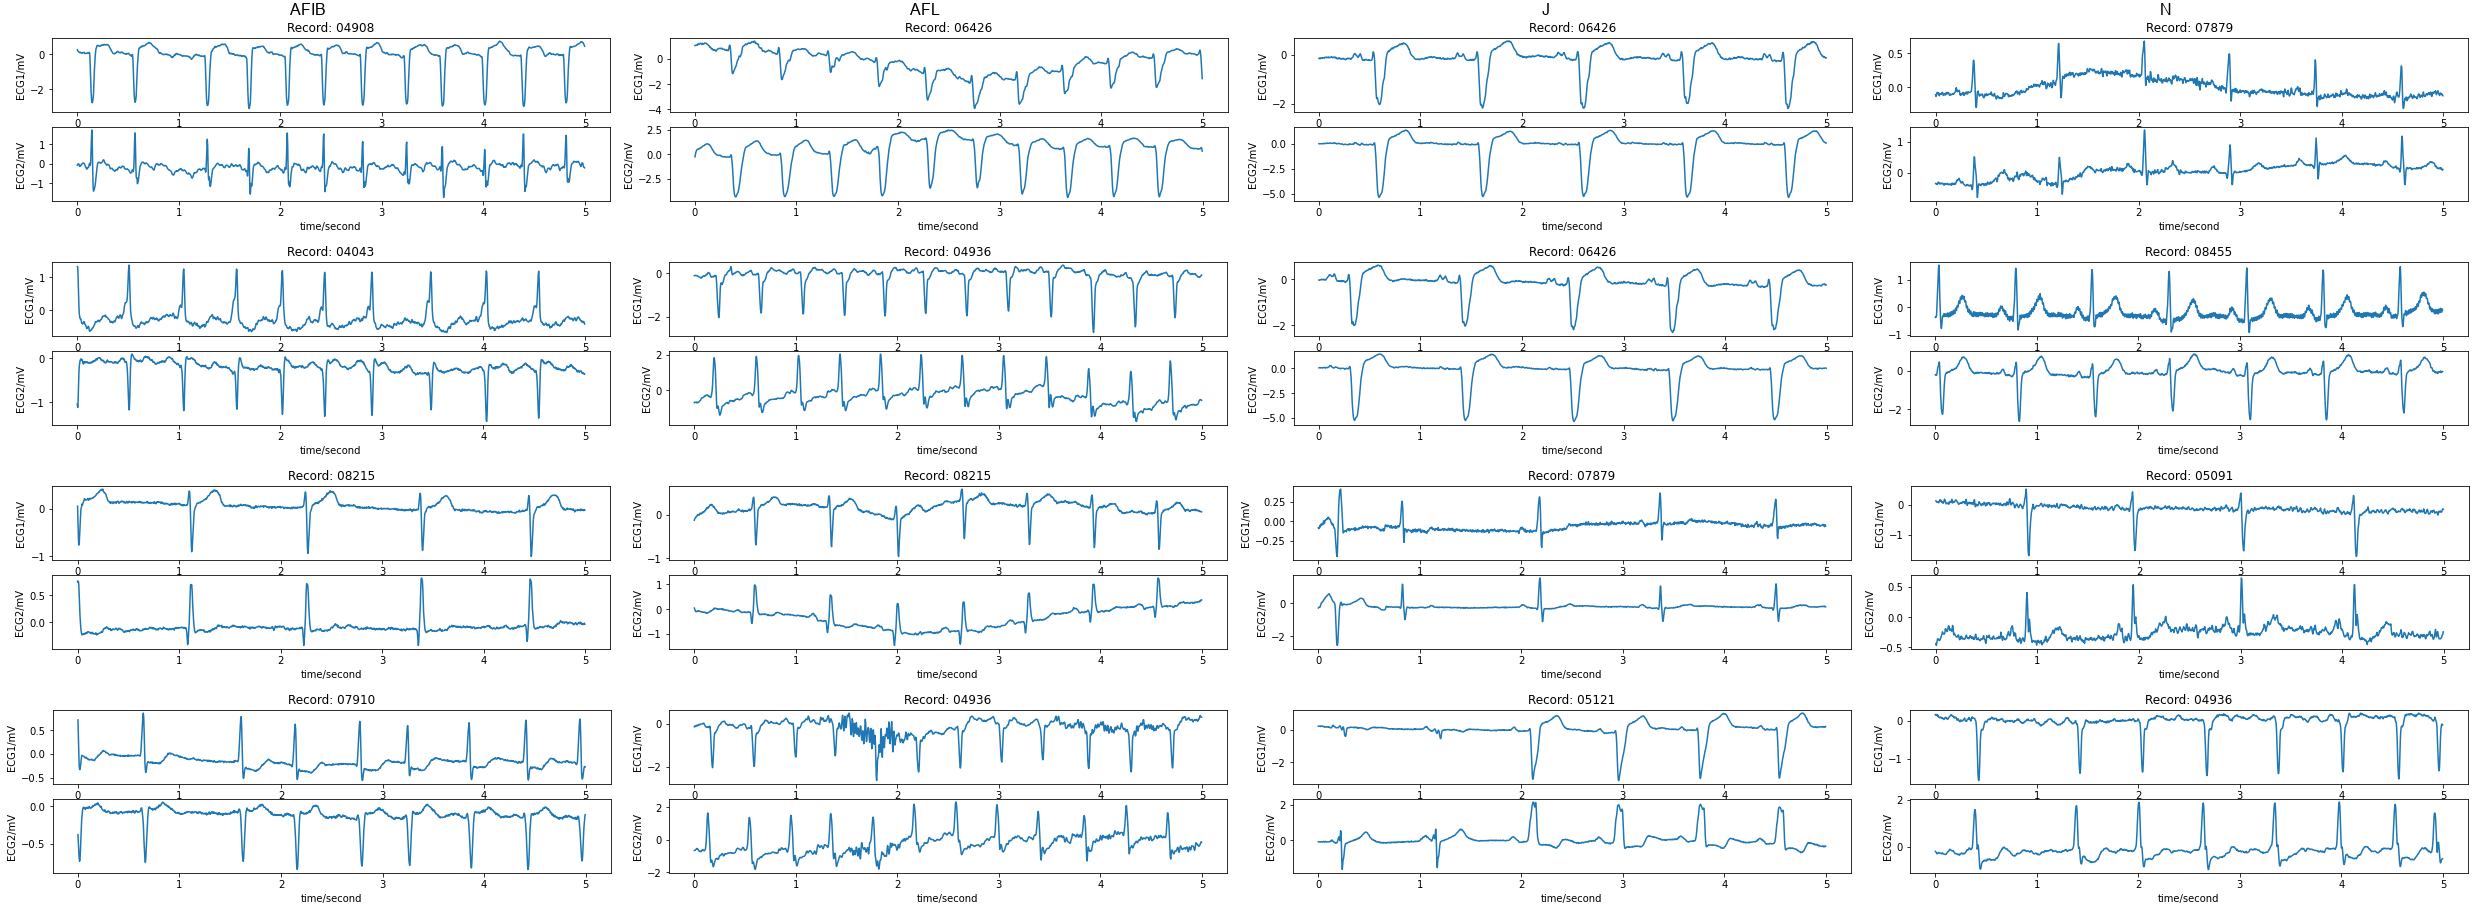

In [4]:
ipy_Image(filename='assets/1x4.png') 

### Similarities
- There seems to be a common pattern to each beat: 
    1. First comes lead-up activity: a small positive mound just before a beat.
    2. The beat itself (characterized by either a large positive spike, a large negative spike, or small spike quickly followed by a large spike).
    3. Follow-up activity: a medium-sized positive mound immediately after a beat
- Signals tend to return to 0 mV or slightly below 0 mV between beats.

### Differences
- Nothing particularly stands out in this view of the data

## Frequency Domain Analysis

Since nothing really stood out between the different rythms, perhaps another view of the data might prove more informative. Using the same sample, I plotted their Discrete Fourier Transforms and noted some observations below.

<table style='font-size:14px'>
<thead>
  <tr>
    <th>AFIB</th>
    <th>AFL</th>
    <th>J</th>
    <th>N</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>• Hard to notice distinct harmonic banding<br>• Noisy †<br></td>
    <td>• Clear harmonic banding<br>• High frequency fundamental</td>
    <td>• Sometimes strong harmonic banding<br>• Low frequency fundamental<br>• Slightly noisy †</td>
    <td>• Occasionally strong harmonic banding<br>• Records 05091 and 04936 are a little noisy †<br>• Record 08455 has 60 Hz noise<br>(probably a product of the data capture process)</td>
  </tr>
</tbody>
</table>

† I should be careful when I say "noisy". If you actually look at the signals they derived from, they aren't so noisy per say. However, in the frequency domain, it is hard distinguished harmonic spikes like we see in the other signals.

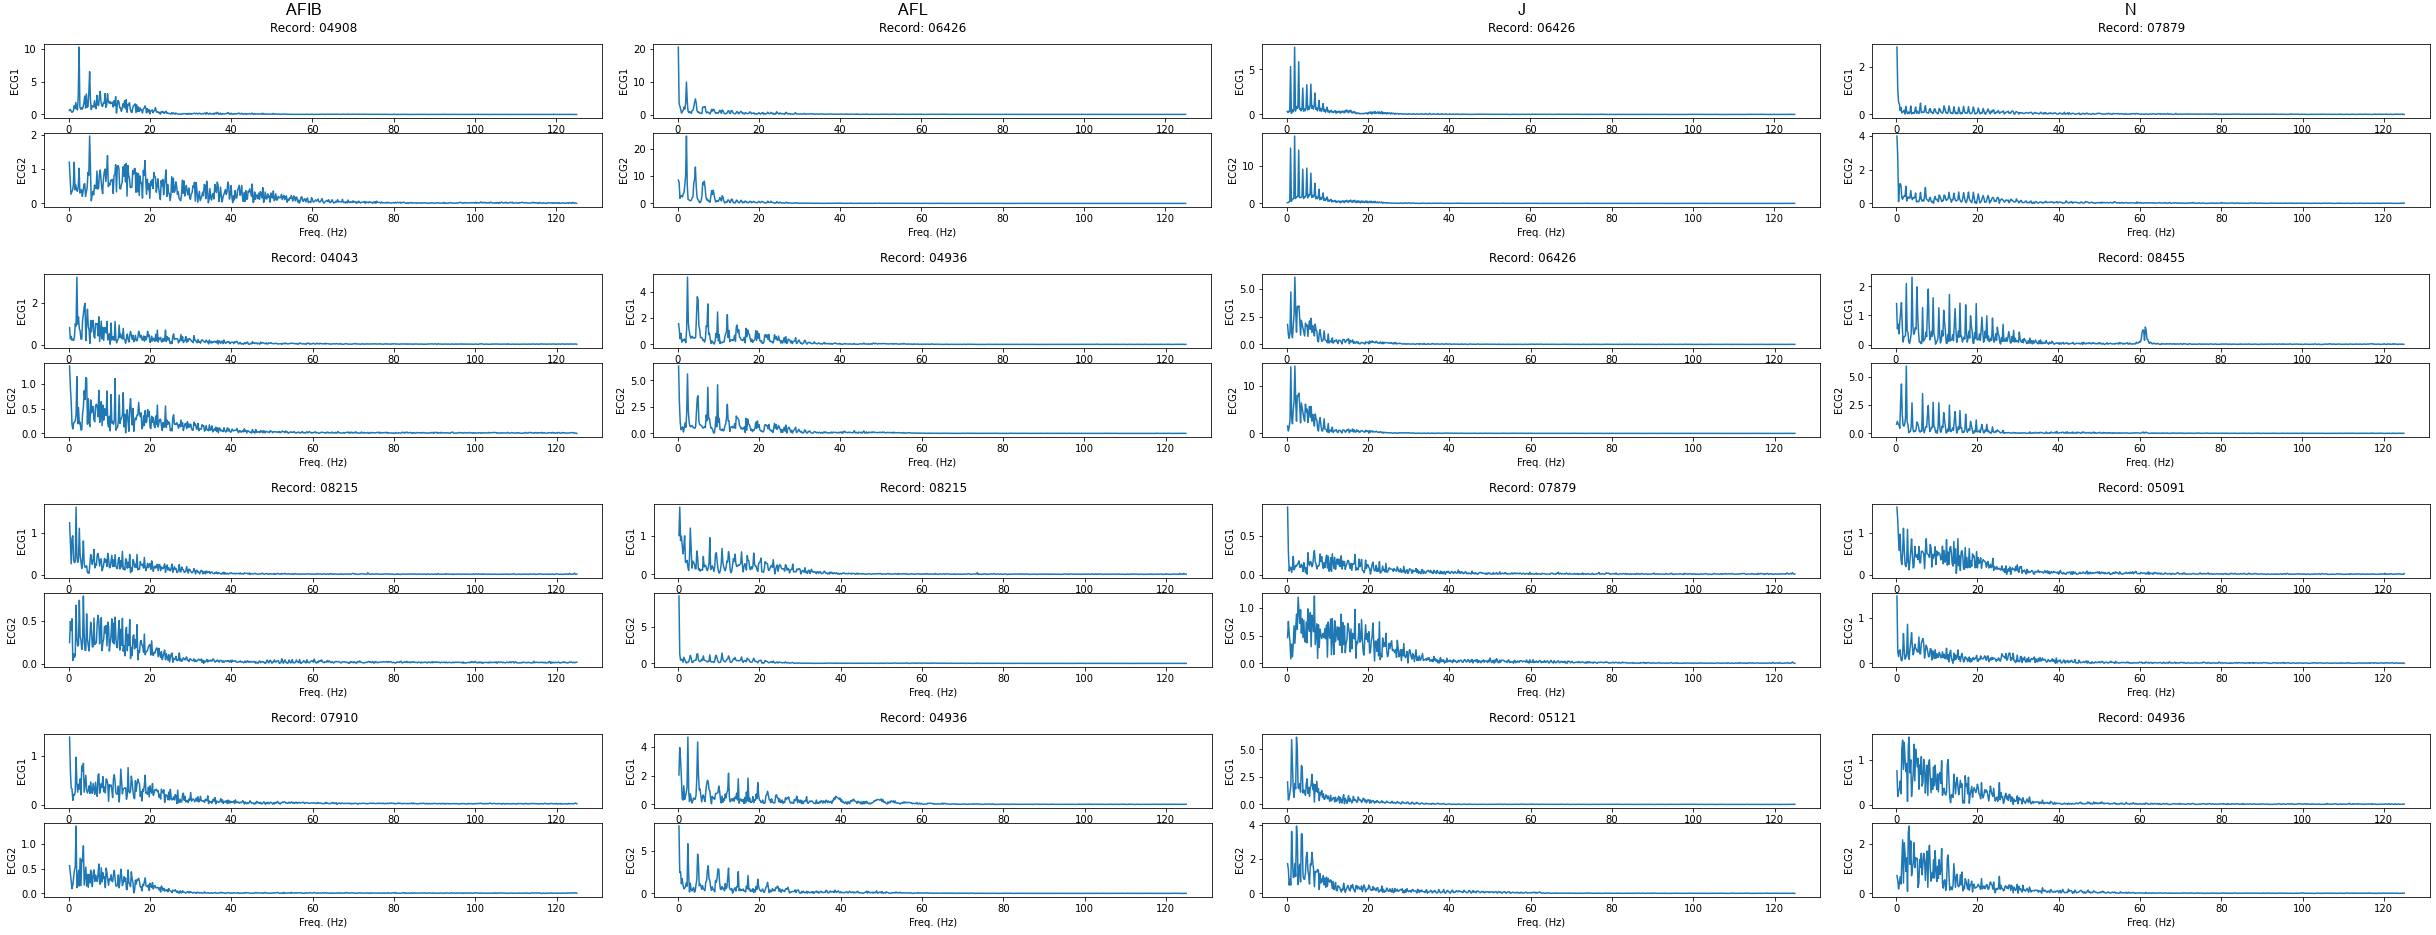

In [5]:
ipy_Image(filename='assets/1x4_dft.png') 

### Aggregated FDA

To do a more general comparison, I took 200 samples for each class, applied a Discrete Fourier Transform, and averaged their values to generate the plot below.

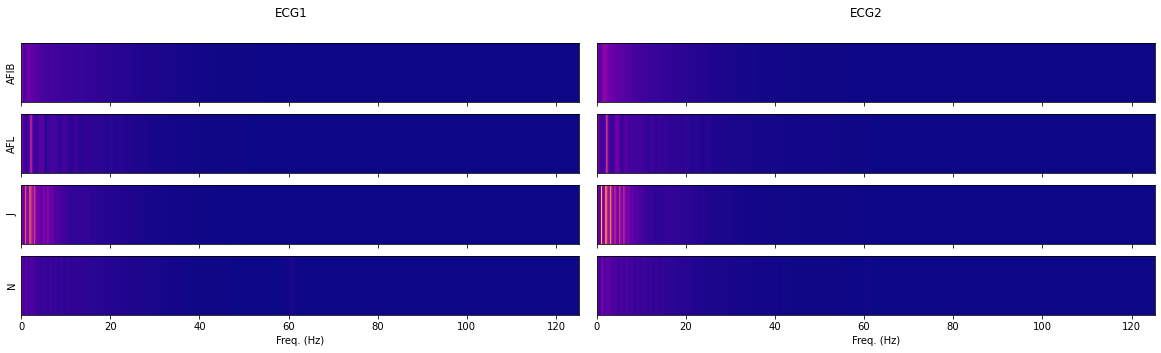

In [6]:
ipy_Image(filename='assets/mean_ecg_dft.png')

The only real distinction I can make is sharpness in the banding for each rythym. However, I believe this doesn't really inform us much about the characteristics of each class. We can expect banding as the result of the harmonics produced by the beat rythym. The sharpness of this banding is likely a result of the variance in each label. AFL and J will have low variance due to the limited number of samples available for them while AFIB and N have higher variance since they have a larger sample pool. Thus, AFL and J appear "sharper" while AFIB and N are more "fuzzy".

There is a slight contradiction though. AFIB and N do not follow this pattern. N has slightly more sample availability than AFIB, having about 20% more data available by duration and appearing in more unique occasions that last longer than 5 seconds. Still, AFIB appears to have more variance making it hard to distinguish any clear harmonics. Meanwhile, N has some pretty evident harmonic banding. 

One explanation could be due to AFIB appearing in 23 records while N only appears in 21. If this is the case, then I theorize that N's appearance in this plot will become more fuzzy as I increase the sample size for each class. I tested this at two other sample sizes. At 1,000, I observed slightly more variance in both N and AFIB, but harmonic banding remained distinguishable in N. At 10,000 there was no noticable difference than that at the 1,000 level. From this experiment, I can't conclusively say that this isn't the case.

Another explanation could be that AFIB rythyms simply have more variation in BPM resulting in this plot appearing less sharp.

One final explanation might be more clear if we reference the previous frequency domain plot.  Recall how I noted that the AFIB plots had indistinguishable spikes. This may indicate the AFIB signals are more eratic resulting in their aggregates appearing as they do.